# Proyecto Final - Redes Neuronales

### Colaboradores:
* José Ávalos Rivera
* Luis Rodrigo Santamaría Rodríguez

## <font color='red'> Sloan Digital Sky Survey
</font>

Sloan Digital Sky Survey (SDSS), ofrece datos públicos de observaciones espaciales. Los datos consisten en 10.000 observaciones del espacio tomadas por el SDSS. Cada observación se describe mediante 17 columnas de características y 1 columna de clase que la identifica como una estrella, una galaxia o un cuásar.

Datos: https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey

In [1]:
#Se importan las librerias que se van a ocupar. 
import numpy as np
import matplotlib.pyplot as plt 
from math import floor
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import torchmetrics as metrics
from sklearn.model_selection import train_test_split
import time

In [2]:
data_raw = pd.read_csv("./Skyserver.csv")
data_raw.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


<font color='red'> RA es la ascencion recta del objeto, dec es la inclinacion. </font>

<img src="https://drive.google.com/uc?id=1pXVcJ5_LjuAljDdfwo5-28ZLnTKFR2fl">


Ascensión recta Explicación, Símbolos y abreviaturas. (2023). Retrieved 1 June 2023, from https://hmong.es/wiki/Right_ascension

---

* Se eliminan las variables **objid** y **rerun**.
* Se aplica onehot encoding a la variable **class**.

In [3]:
data = data_raw.loc[:, ~data_raw.columns.isin(["objid", "rerun"])]
data = pd.concat([data, pd.get_dummies(data["class"])], axis = 1)
data = data.loc[:, data.columns != "class"]
data.head()

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,redshift,plate,mjd,fiberid,GALAXY,QSO,STAR
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,4,267,3.722360e+18,-0.000009,3306,54922,491,0,0,1
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,4,267,3.638140e+17,-0.000055,323,51615,541,0,0,1
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,4,268,3.232740e+17,0.123111,287,52023,513,1,0,0
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,4,269,3.722370e+18,-0.000111,3306,54922,510,0,0,1
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,4,269,3.722370e+18,0.000590,3306,54922,512,0,0,1


---

### Histogramas

In [90]:
def histogramas(*variables, data, figsize = (15, 6), subplots):
    plt.style.use("ggplot")
    plt.figure(figsize= figsize)
    n_vars = len(variables)
    colors = ["blue", "green", "purple", "red", "yellow", "orange"]
    subplots_list = [plt.subplot(*subplots, i) for i in range(1, n_vars + 1)]

    for i, subplot in enumerate(subplots_list):
        subplot.hist(data[variables[i]], color = random.choice(colors),
                     edgecolor = "black", alpha = 0.6, bins = 20)
        subplot.set_xlabel(variables[i])
        
        if (i == 0):
            subplot.set_ylabel("Conteo", size = 15)
    plt.show()

    

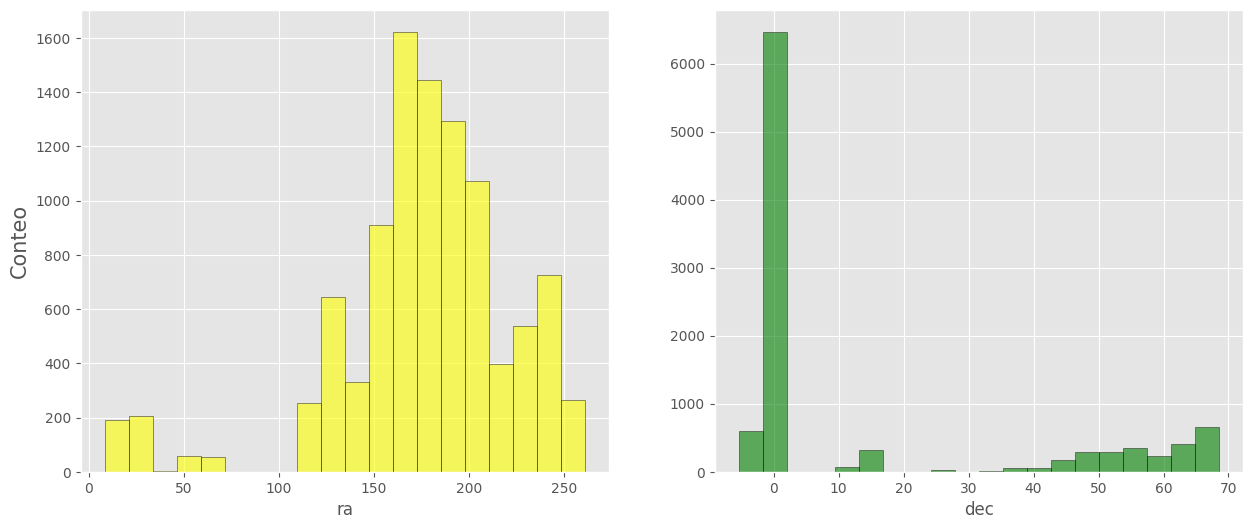

In [91]:
histogramas("ra", "dec", data = data, subplots = (1, 2))

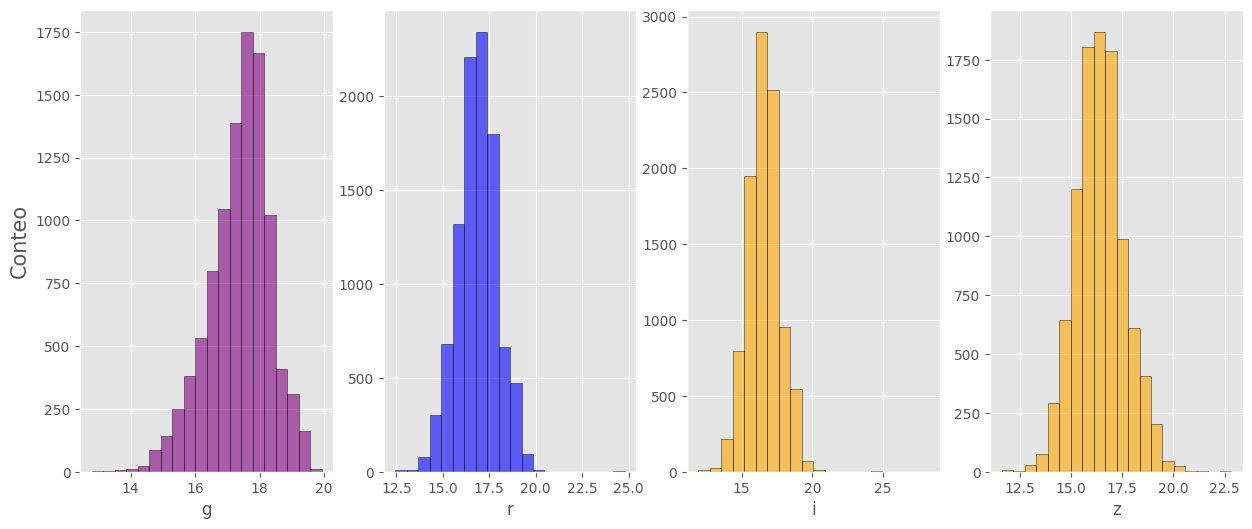

In [92]:
histogramas("g", "r", "i", "z", data = data, subplots = (1, 4))

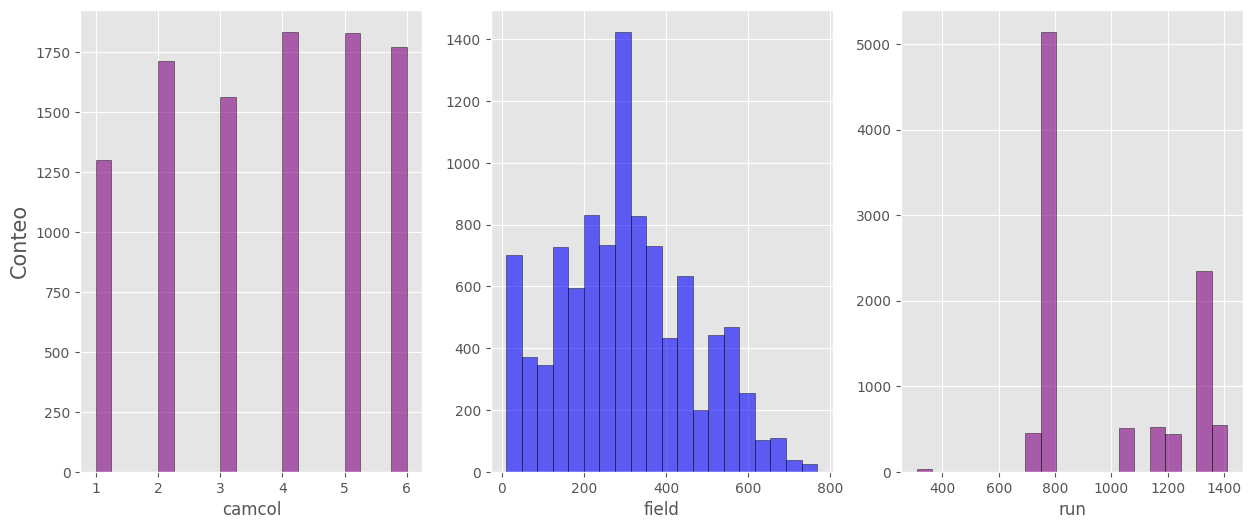

In [93]:
histogramas("camcol", "field", "run", data = data, subplots = (1, 3))

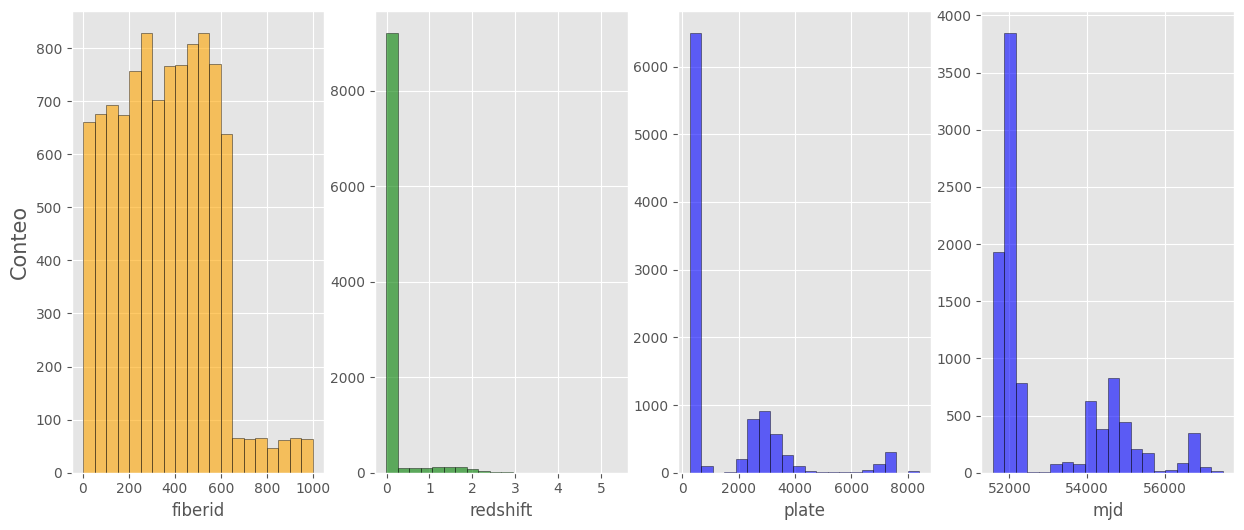

In [94]:
histogramas("fiberid", "redshift", "plate", "mjd", data = data, subplots = (1, 4))

---
### Procesamiento de los datos

* Se normalizan las variables predictivas
* Se dividen los datos en train (80%) y test (20%).

In [95]:
def preparar_data(data):
    # X = data.loc[:, data.columns != "class"]
    # Y = data.loc[:, data.columns == "class"]
    X = data.loc[:, ~data.columns.isin(["GALAXY", "QSO", "STAR"])]
    Y = data.loc[:, data.columns.isin(["GALAXY", "QSO", "STAR"])]
    X, Y = torch.tensor(X.values).float(), torch.tensor(Y.values).float()

    X_means = X.mean(dim = [0])
    X_std = X.std(dim = [0])
    X = (X - X_means) / X_std
    return (*train_test_split(X, Y, train_size= 0.8), X_means, X_std)


In [96]:
x_train, x_test, y_train, y_test, x_means, x_std = preparar_data(data)

---
# Estructura Red Neuronal
* Capa de entrada: 15 variables. Activación Sigmoide.
* Primer capa oculta: 150 neuronas con activación Sigmoide, Dropout con probabilidad 0.5 y normalización.
* Segunda capa oculta: 100 neuronas con activación Sigmoide, Dropout con probabilidad 0.5 y normalización.
* Tercer capa oculta: 100 neuronas con activación Sigmoide.
* Cuarta capa oculta:  50 neuronas.
* Capa de Salida: 3 neuronas y Softmax.

Función de Error: Entropía Cruzada.

Optimizador: Adam con learning rate = 0.001, $\beta$ 's = (0.9, 0.999).

In [107]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, hidden3, hidden4, output_size):

        super(RNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden1, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Linear(hidden1, hidden2, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(hidden2),
            nn.Linear(hidden2, hidden3, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(hidden3),
            nn.Linear(hidden3, hidden4, bias = False, dtype = torch.float),
            nn.Sigmoid(),
            nn.Linear(hidden4, output_size, bias = False, dtype = torch.float)
        )
    
    def forward(self, X):
        out = self.layers(X)
        out = nn.functional.softmax(out, dim = 1)
        return out
    
    def back_propagate(self, X, Y):
        out = self.forward(X)
        f_error = nn.CrossEntropyLoss()
        error = f_error(out, Y)
        error.backward()
        return error

    def train(self, X_train, Y_train, optimizer, confusion = {"plot": False}, ciclos = 100):
        self.optimizer = optimizer
        loss = []
        acc_train = []
        acc_test = []
        for i in range(ciclos):
            self.optimizer.zero_grad()
            loss.append(self.back_propagate(X_train, Y_train).detach().numpy())
            self.optimizer.step()
            
            if confusion["plot"]:
                pred_train = self.forward(X_train)
                pred_test = self.forward(confusion["x_test"])
                
                confmat_train = self.confusion(pred_train, Y_train)
                confmat_test = self.confusion(pred_test, confusion["y_test"])
                
                acc_train.append((confmat_train[0,0] + confmat_train[1,1]) / confmat_train.sum() * 100)                
                acc_test.append((confmat_test[0,0] + confmat_test[1,1]) / confmat_test.sum() * 100)
    
        if confusion["plot"]:
            return loss, acc_train, acc_test
        
        return loss

    def confusion(self, y_pred, y_true):
        confmat = metrics.ConfusionMatrix(task = "binary", num_classes = 2)
        return confmat(y_pred, y_true)


In [135]:
Red = RNN(15, 150, 100, 100, 50, 3)
optimizer = optim.Adam(Red.parameters(), lr = 0.001)
ciclos = 100
conf_parameters = {"plot": True, "x_test": x_test, "y_test": y_test}

---
### Entrenamiento

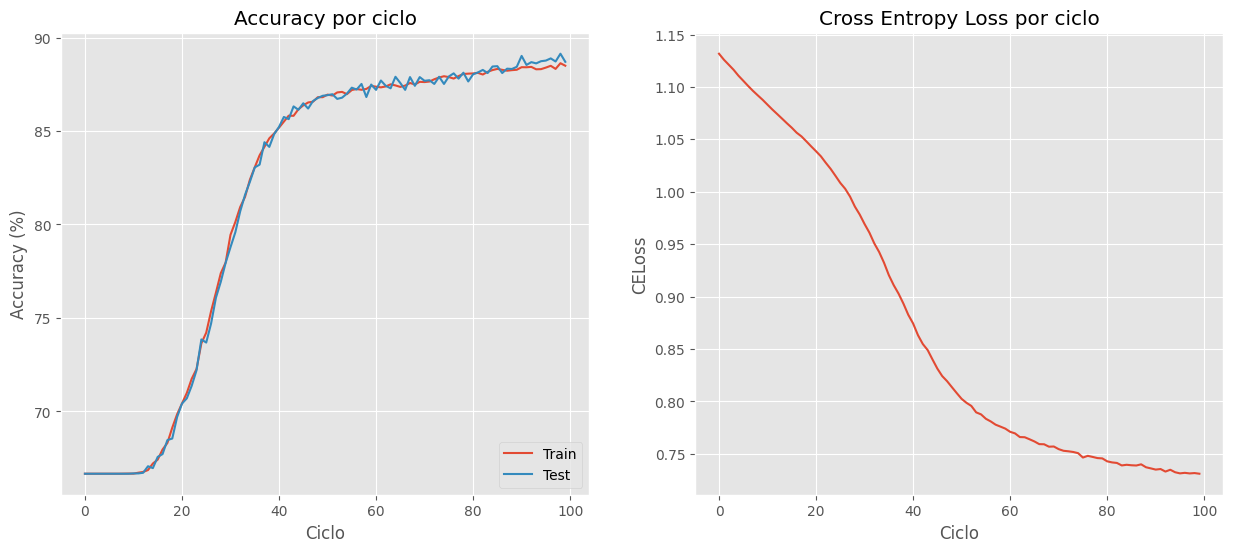

In [136]:
plt.style.use("ggplot")
plt.figure(figsize= (15, 6))
if conf_parameters["plot"]:
    loss, acc_train, acc_test = Red.train(x_train, y_train, optimizer = optimizer, confusion = conf_parameters,ciclos = ciclos)
    
    acc_plot = plt.subplot(1, 2, 1)
    acc_plot.plot(acc_train)
    acc_plot.plot(acc_test)
    acc_plot.set_title("Accuracy por ciclo")
    acc_plot.legend(['Train', 'Test'], loc='lower right')
    acc_plot.set_xlabel("Ciclo")
    acc_plot.set_ylabel("Accuracy (%)")
    # acc_plot.set_ylim(min(acc), 100)
else:
    loss = Red.train(x_train, y_train, optimizer = optimizer, confusion = conf_parameters, ciclos = ciclos)

loss_plot = plt.subplot(1, 2, 2)
loss_plot.plot(loss)
loss_plot.set_title("Cross Entropy Loss por ciclo")
loss_plot.set_xlabel("Ciclo")
loss_plot.set_ylabel("CELoss")

plt.show()

In [139]:
torch.save(Red.state_dict(), "./SDSS_model.pt")
    

Se cargan los pesos:

In [ ]:
Red = RNN(15, 150, 100, 100, 50, 3)
Red.load_state_dict(torch.load("./SDSS_model.pt"))

---
### Matriz de Confusión

In [155]:

confus = Red.confusion(Red(x_test), y_test)
print(f"Matriz de Confusión: \n {confus}")
print(f"Accuracy: {((confus[0, 0] + confus[1, 1]) / confus.sum()) * 100}%")

Matriz de Confusión: 
 tensor([[3672,  328],
        [ 351, 1649]])
Accuracy: 88.68333435058594%
